# Better Long-Term Stock Forecasts

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

The [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) showed a strong predictive relationship between the P/Sales ratio and long-term returns of some individual stocks and the S&P 500 stock-market index. 

However, there was a considerable amount of noise in those scatter-plots, because we considered fixed investment periods of exactly 10 years, for example. So even though the P/Sales ratio was a strong predictor for the mispricing at the buy-time, it was impossible to predict the mispricing at the sell-time, because the stock-market could be in a bubble or in a crash 10 years into the future, which would distort the estimated returns.

This paper presents a simple solution, which is to consider the average returns for all investment periods between 7 and 15 years, and then make a scatter-plot of the mean returns versus the P/Sales ratio. This produces incredibly smooth curves for estimating the future long-term returns of the S&P 500 and some individual stocks.

Along with the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb), this is a very important discovery and it has implications for many areas of both theoretical and applied finance. It means that the U.S. stock-market as a whole is not "efficient" and does not follow a purely "random walk" in the long-term. It is possible to estimate the future long-term return of the stock-market and some individual stocks from just a single indicator variable.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import os

In [3]:
# Imports from FinanceOps.
from curve_fit import CurveFitReciprocal
from data_keys import *
from data import load_index_data, load_stock_data
from returns import prepare_mean_ann_returns

## Load Data

We now load all the financial data we will be using.

In [4]:
# Define the ticker-names for the stocks we consider.
ticker_SP500 = "S&P 500"
ticker_JNJ = "JNJ"
ticker_K = "K"
ticker_PG = "PG"
ticker_WMT = "WMT"

In [5]:
# Load the financial data for the stocks.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_JNJ = load_stock_data(ticker=ticker_JNJ)
df_K = load_stock_data(ticker=ticker_K)
df_PG = load_stock_data(ticker=ticker_PG)
df_WMT = load_stock_data(ticker=ticker_WMT)

## Plotting Functions

These are helper-functions used for making plots.

In [6]:
def plot_psales(df, ticker, start_date=None):
    """
    Plot the P/Sales ratio.

    :param df: Pandas DataFrame with PSALES.
    :param ticker: Ticker-name for the stock or index.
    :param start_date: Start-date for the plot.
    :return: Nothing.
    """

    psales = df[PSALES][start_date:].dropna()
    psales.plot(title=ticker + " - P/Sales", grid=True)

In [7]:
def plot_ann_returns(ticker, df, key=PSALES,
                     min_years=7, max_years=15,
                     use_colors=True):
    """
    Create a single scatter-plot with P/Sales or P/Book
    vs. Mean Annualized Returns for e.g. 7-15 years.
    
    :param ticker: Ticker-name for the stock or index.
    :param df: Pandas DataFrame containing key and TOTAL_RETURN.
    :param key: Name of data-column to use e.g. PSALES or PBOOK.
    :param min_years: Min number of years for return periods.
    :param max_years: Max number of years for return periods.
    :param use_colors: Boolean whether to use colors in plot.
    :return: Nothing.
    """

    # Prepare the data.
    # x is the P/Sales or P/Book and y is the Mean Ann. Returns.
    x, y = prepare_mean_ann_returns(df=df, key=key,
                                    min_years=min_years,
                                    max_years=max_years)

    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Scatter-plot.
    if use_colors:
        # Give each dot in the scatter-plot a shade of blue
        # according to the date of the data-point.
        ax.scatter(x, y,
                   c=list(range(len(x))), cmap='Blues',
                   alpha=1.0, marker='o')
    else:
        # Use the same color for all dots.
        ax.scatter(x, y, marker='o')
        
    # First part of the title.
    title1 = "[{0}] {1} vs. {2}-{3} Years Mean Ann. Return"
    title1 = title1.format(ticker, key, min_years, max_years)

    # X-values for plotting fitted curves.
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = np.arange(x_min, x_max, (x_max/x_min)/1000)
    
    # Plot reciprocal curve-fit.
    curve_fit_reciprocal = CurveFitReciprocal(x=x, y=y)
    y_pred = curve_fit_reciprocal.predict(x=x_range)
    ax.plot(x_range, y_pred, color='red')
    # Title with these curve-fit parameters.
    title2 = "Mean Ann. Return = {0:.1%} / " + key + " + {1:.1%}"
    title2 = title2.format(*curve_fit_reciprocal.params)

    # Combine and set the plot-title.
    title = "\n".join([title1, title2])
    ax.set_title(title)

    # Set axis labels.
    ax.set_xlabel(key)
    ax.set_ylabel("Mean Ann. Return")
    
    # Convert y-ticks to percentages.
    # We use a custom FuncFormatter because PercentFormatter
    # is inconsistent with string-formatters used elsewhere.
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    ax.yaxis.set_major_formatter(formatter)
    
    # Show grid.
    ax.grid()
    
    # Show the plot.
    plt.show()

## Case Study: S&P 500

The S&P 500 is a stock-market index consisting of the stocks of 500 of the largest companies in USA. The S&P 500 covers about 80% of the whole U.S. stock-market in terms of size so it is useful as a gauge for the entire U.S. stock-market.

We consider the Total Return of the S&P 500 which is what you would get from investing in the S&P 500 and re-investing all dividends back into the S&P 500. We ignore all taxes here.

The following scatter-plot shows the P/Sales ratio versus the Mean Annualized Returns of the S&P 500 for periods between 7 and 15 years.

For each day we calculate the Total Return of the S&P 500 over the next 7-15 years, then we calculate the Mean Annualized Return from those, and then we put a blue dot in the scatter-plot for that date's P/Sales ratio and the Mean Annualized Return we just calculated. This process is continued for all days in the time-series, until we have calculated and plotted the P/Sales vs. Mean Annualized Return for all days.

As can be seen from this scatter-plot, the P/Sales ratio is a very strong predictor for long investment periods between 7-15 years. We call the fitted red curve for the "return curve".

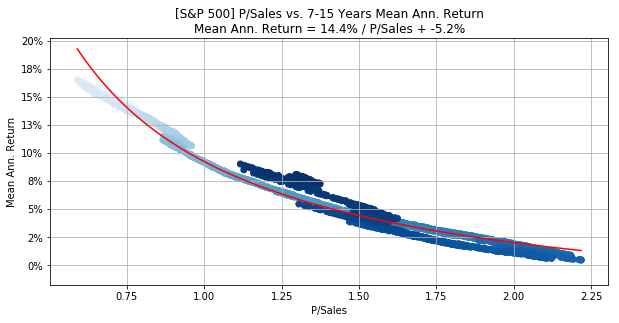

In [8]:
plot_ann_returns(ticker=ticker_SP500, df=df_SP500, key=PSALES,
                 min_years=7, max_years=15, use_colors=True)

We can forecast the future long-term returns using the fitted "return curve" from the scatter-plot above. Towards the end of 2017, the P/Sales ratio was almost 2.2 for the S&P 500, which was about the previous high point of the "Dot-Com" bubble around year 2000.

In [9]:
df_SP500[PSALES].dropna().tail(1)

Date
2017-12-29    2.170896
Name: P/Sales, dtype: float64

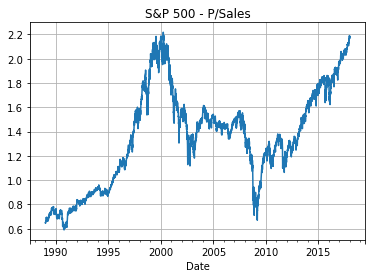

In [10]:
plot_psales(df=df_SP500, ticker=ticker_SP500)

So if you purchased the S&P 500 in December 2017 at this P/Sales ratio and will keep the investment for more than 7 years, while reinvesting all dividends during those years (all taxes are ignored), then the formula forecasts an annualized return of about 1.35%:

$$
Annualized\ Return = 14.4\% / (P/Sales) - 5.2\% = 14.4\% / 2.2 - 5.2\% \simeq 1.35\%
$$

The formula cannot predict exactly what will happen in the future, because there might be a stock-market bubble or a crash in any given year. The formula merely predicts an average annualized return for long-term investments of about 7-15 years in the S&P 500.

## Case Study: Johnson & Johnson (JNJ)

Now let us consider individual companies instead of a whole stock-market index. The first company we consider is Johnson & Johnson with the ticker symbol JNJ. This is a very large company with over 130.000 employees worldwide that manufacture a wide range of health-care related products.

When we plot the P/Sales ratio versus the mean annualized return for 7-15 year periods, we see that the "return curve" fits quite well although there appears to be a few separate "return curves" for P/Sales ratios roughly between 2 and 3.

The blue shades in the scatter-plot indicate the time of the data-points and suggest that the separate curves belong to different periods of time. More research would be needed to establish why these periods have different "return curves". Perhaps the periods had significantly different profit-margins or sales-growth.

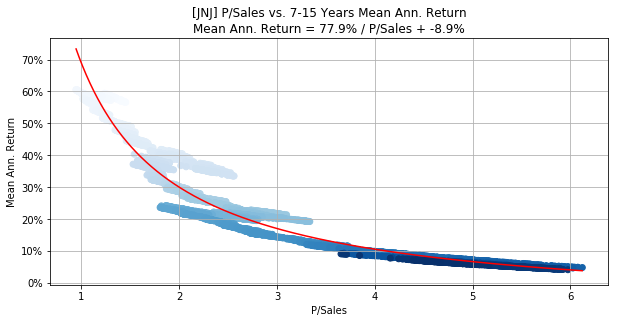

In [11]:
plot_ann_returns(ticker=ticker_JNJ, df=df_JNJ, key=PSALES,
                 min_years=7, max_years=15, use_colors=True)

Towards the end of 2017 the P/Sales ratio was about 4.9 which is close to the all-time historical highs experienced during the stock-market bubble around year 2000.

In [12]:
df_JNJ[PSALES].dropna().tail(1)

Date
2017-12-31    4.895577
Freq: D, Name: P/Sales, dtype: float64

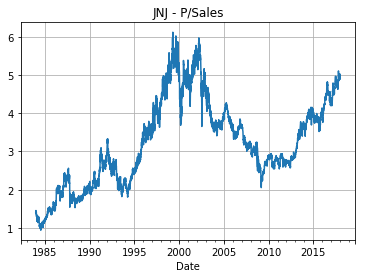

In [13]:
plot_psales(df=df_JNJ, ticker=ticker_JNJ)

Using the formula for the fitted "return curve" from the scatter-plot above, we get this forecasted long-term return:

$$
Annualized\ Return \simeq 77.9\% / (P/Sales) - 8.9\%
\simeq 77.9\% / 4.9 - 8.9\% \simeq 7.0\%
$$

So according to this formula, the annualized return of the JNJ stock will be around 7.0% if you own the stock for at least 7 years, when dividends are reinvested and ignoring taxes.

Again there is the caveat that it is impossible to predict whether there will be a stock-market bubble or crash several years into the future, so the forecasted return is an average for 7-15 year investment periods.

## Case Study: Procter & Gamble (PG)

Another very large company is Procter & Gamble with the ticker symbol PG, which sells a wide range of consumer products and has almost 100.000 employees.

If we plot the P/Sales ratio versus the mean annualized return we get an incredibly regular curve of data-points. The red line shows a reciprocal curve-fit, which is apparently not the correct formula for this data, as it doesn't fit so well at the ends. You are encouraged to try and find a better curve-fit and a theoretical explanation why your formula is better.

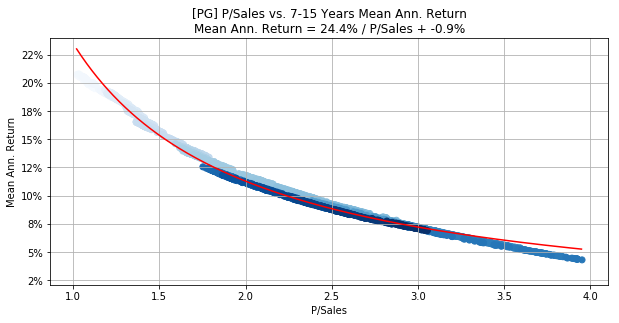

In [14]:
plot_ann_returns(ticker=ticker_PG, df=df_PG, key=PSALES,
                 min_years=7, max_years=15)

When we plot the historical P/Sales ratio, we see that at the end of 2017 it was around 3.5 which was near its all-time high experienced during the bubble around year 2000.

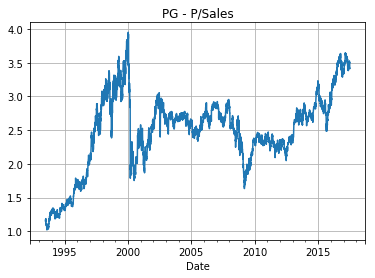

In [15]:
plot_psales(df=df_PG, ticker=ticker_PG)

Using the fitted reciprocal curve from the scatter-plot above, we get a forecasted return of about 6.1% per year, when dividends are reinvested without taxes:

$$
Annualized\ Return \simeq 24.4\% / (P/Sales) - 0.9\% \simeq 
24.4\% / 3.5 - 0.9\% \simeq 6.1\%
$$

But it should again be noted that this formula doesn't fit so well towards the ends of the data, and looking at the scatter-plot suggests a slightly lower return of maybe 5.5%.

## Case Study: Kellogg's (K)

The next company is Kellogg's which trades under the ticker symbol K. The company has about 33.000 employees and is especially known for making breakfast cereals.

When we plot the P/Sales ratio versus the mean annualized return it shows a strong trend that higher P/Sales ratios gives lower long-term returns, although the curve-fit is not as good as for the other companies we studied above, especially for lower P/Sales ratios.

The blue shades show the time of the data-points. It can be hard to see in this plot, but for P/Sales ratios between 1.50 and 1.75, there is a "blob" of light-blue data-points well above the fitted red curve. This clearly indicates that the outlying data-points belong to a specific period in time. But we would have to do more research into the financial data for that period, to uncover the reason why the returns are so different.

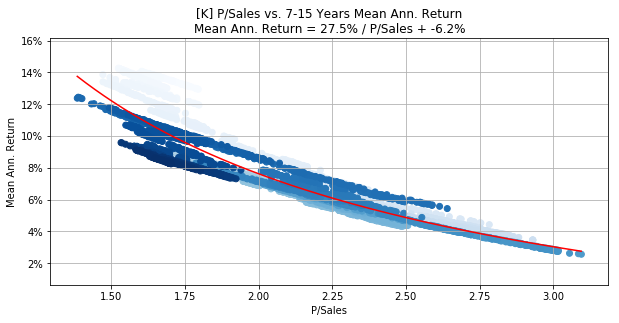

In [16]:
plot_ann_returns(ticker=ticker_K, df=df_K, key=PSALES,
                 min_years=7, max_years=15, use_colors=True)

Towards the end of 2017 the P/Sales ratio was about 1.8 which was actually very close to the historical average.

In [17]:
df_K[PSALES].dropna().mean()

1.8626938835082578

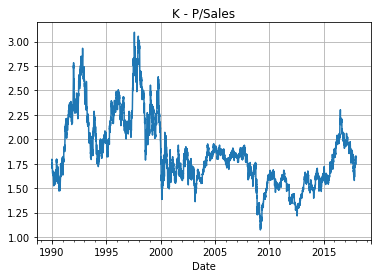

In [18]:
plot_psales(df=df_K, ticker=ticker_K)

Using the fitted "return curve" from the scatter-plot above with the P/Sales ratio of 1.8 we get the forecasted return:

$$
Annualized\ Return \simeq 27.5\% / (P/Sales) - 6.2\% \simeq 
27.5\% / 1.8 - 6.2\% \simeq 9.1\%
$$

So a forecasted return of about 9.1% per year over the next 7-15 years when dividends are reinvested without taxes. That is about 2% (percentage points) higher than the return forecasted for JNJ and 3% higher than forecasted for PG above.

## Case Study: Wal-Mart (WMT)

Now let us consider the company Wal-Mart which trades under the ticker symbol WMT. It is an extremely large retail-company with about 2.3 million employees.

If we plot the P/Sales ratio versus the mean annualized return, we see that the red curve fits very poorly. There seems to be several separate trends in the data, and the blue shades indicate that the trends belong to different periods in time. But more research into the company's financial history would be needed to uncover the reason for this, perhaps it is because of significantly different sales-growth, profit margins, etc.

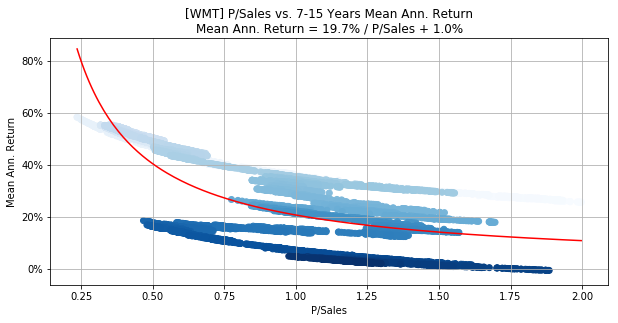

In [19]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT, key=PSALES,
                 min_years=7, max_years=15, use_colors=True)

## Conclusion

We have shown that the P/Sales ratio is a very strong predictor for the long-term returns of the S&P 500 index and some individual stocks.

In the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) we considered fixed investment periods of e.g. 10 years, which meant that the investment return depended on the P/Sales ratio both at the time of buying and selling. This distorted the data because sometimes the stock-market would be in a bubble or crash 10 years later.

In this paper we presented a simple solution by considering all investment periods between 7 and 15 years, and then using the average return instead. This averages out the distorting effects of future bubbles and crashes, so we get much more smooth data that only depends on the P/Sales ratio at the buy-time.

We then fitted a reciprocal "return curve" to the scatter-plots, and although it generally had a very tight fit, it was not so accurate towards the end-points, thus suggesting that the reciprocal formula is not entirely correct for this data. It would be of great interest to not only find a mathematical model that fits better, but also a theoretical explanation why that model makes sense. Perhaps such a model would also allow us to use smaller amounts of data and take into account the changing economics of a business. Perhaps we could use such a model to forecast returns of more companies where the basic method does not work so well, such as Wal-Mart as demonstrated above.

It should be stressed that the forecasted returns will also depend on a *qualitative* assessment of the company. If the company's future will be significantly different from its historical sales, profit-margins and growth, then the forecasted returns will be inaccurate. That is why this forecasting method is perhaps best used on broad stock-market indices such as the S&P 500, or companies whose products and markets are expected to be highly predictable long into the future.

## Research Ideas

You are strongly encouraged to do more research on this topic. If you make any new discoveries then please let me know your results. 

To my knowledge, there are no academic studies of predicting the long-term returns of stocks and stock-markets as we have done here. This work has presented the basic idea and methodology, but a lot more research can be done on this subject and it may impact many areas of both theoretical and applied finance.

Here are a few more research ideas to get you started, in addition to the ideas from the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb):

- Try other investment periods, for example 5 to 10 years. How does it change the scatter-plots and the fitted "return curves"?
- Try using P/Book as the predictor signal. How does that affect the plots? Why?
- Although the data in some of these scatter-plots is incredibly smooth, the reciprocal curve does not fit the data exactly, which suggests that it is the wrong formula for this data. Can you find a better formula and perhaps give a theoretical explanation why that is better?
- What is the reason that some companies such as Wal-Mart have several different trend-lines in the scatter-plot? You will probably need to investigate the historical financial data to uncover the reason. Can you modify the forecasting method to somehow take this into account?

## License (MIT)

Copyright (c) 2015-18 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.